In [1]:
from keras import losses
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Activation, Reshape, UpSampling2D, Dense
from keras.layers.merge import concatenate
from keras.layers import Flatten
from keras.utils import to_categorical
from keras.optimizers import Adadelta, SGD, Adam
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
#from scipy.misc import imresize
from keras.layers import concatenate
from keras.utils.vis_utils import model_to_dot
from keras.utils import np_utils
from IPython.display import SVG
import matplotlib.pyplot as plt
import os
import numpy as np
import random
import cv2
import time

Using TensorFlow backend.


## Importing data from CSVs. 

In [2]:
features_data = pd.read_csv("15features.csv")
training_data = pd.read_csv("unseen-dataset/dataset_unseen_training_siamese.csv")
validation_data = pd.read_csv("unseen-dataset/dataset_unseen_validation_siamese.csv")

training_data = training_data.drop('Unnamed: 0',1)
validation_data = validation_data.drop('Unnamed: 0',1)

train_path = 'unseen-dataset/TrainingSet/'
train_images = os.listdir(train_path)

val_path = 'unseen-dataset/ValidationSet/'
val_images = os.listdir(val_path)

columns = features_data.columns

features_values = []
for i in columns[1:]:
    features_values.append(features_data[i].unique().shape[0])
features_values

[2, 3, 3, 3, 2, 2, 4, 2, 2, 4, 2, 3, 4, 2, 2]

## Datagen

In [3]:
def datagen(batch_size,image_path,list_of_writers, vshift = (-64,64) ,vis=False):
    counter = 0
    w_ids,ids,x,y,imagenames, feature_list = [],[],[],[],[],[]
    while True:
        writer_index = np.random.randint(0,len(list_of_writers))
        imagename = list_of_writers[writer_index]
        features = features_data[features_data['imagename']==imagename].values
        if len(features)==0:
            continue
        features = features[0][1:]-1
        loaded_image = cv2.imread(os.path.join(image_path,imagename),0)
        rand = np.random.randint(vshift[0],vshift[1])
        loaded_image_shifted=np.roll(axis=0,a=loaded_image,shift=rand)

        x.append(255.0-loaded_image_shifted.reshape((64,64,1)))
        y.append(255.0-loaded_image.reshape((64,64,1)))
        w_ids.append(imagename[:4])
        imagenames.append(imagename)
        ids.append(writer_index)
        feature_list.append(features)
        counter+=1
        if counter == batch_size:
            counter=0
            feature_list = np.array(feature_list)
            feature_list = feature_list.transpose()
            out_cat_features = []
            for i in range(len(feature_list)):
                out_cat_features.append(to_categorical(feature_list[i],num_classes=features_values[i]))
            if vis== True:
                yield np.array(x)/255.0,[np.array(w_ids),np.array(imagenames)]
            else:
                yield np.array(x)/255.0,out_cat_features
            w_ids,ids,x,y,imagenames,feature_list =[], [],[], [],[],[]    

## Seen Dataset AutoEncoder

In [4]:
input_img = Input(shape=(64, 64, 1))

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same', name='encoded')(x)

x = Conv2D(512, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same',name='output')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='categorical_crossentropy', metrics=["accuracy"])
autoencoder.load_weights('saved_model_unseen_mc.h5')
autoencoder.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_

## Creating non-trainable encoder

In [5]:
encoder = Model(autoencoder.input,autoencoder.get_layer('encoded').output)
for layer in encoder.layers:
    layer.trainable = False

#encoder.summary()

# Creating individual Neural Networks for each feature.

In [6]:
dense_layer = encoder.get_layer('encoded').output
out_dense_layer=[]
for i in range(1,len(features_values)+1):
    out_dense_layer.append(Dense(features_values[i-1] , activation='softmax', name = 'out_feature_'+str(i))(Dense(128 , activation='relu', name = 'dense_layer_'+str(i))(Flatten()((dense_layer)))))

human_features = Model(inputs=encoder.input, outputs=out_dense_layer)
human_features.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 16)   160         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 32, 32, 16)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 32)   4640        max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
max_poolin

In [7]:
# display(SVG(model_to_dot(human_features, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg')))
from keras.utils import plot_model
plot_model(human_features, show_layer_names=True, show_shapes=True, to_file='task4AutoEncoderUnseen.png')

## Model  

In [8]:
losses = {}
lossWeights = {}
for i in range(1,16):
    losses["out_feature_"+str(i)] = "categorical_crossentropy"
    lossWeights["out_feature_"+str(i)] = 1.0

EPOCHS = 5000
INIT_LR = 0.0001
batch_size = 64
es = EarlyStopping(patience=10000, monitor='val_loss', min_delta=0.0005, mode='auto')
opt = SGD(lr=INIT_LR, decay=1e-6, momentum=0.95, nesterov=True)

human_features.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy',metrics=["accuracy"])

training_datagen = datagen(batch_size,image_path=train_path,vshift=(-10,10),list_of_writers=train_images)
validation_datagen = datagen(batch_size,image_path=val_path,vshift=(-10,10), list_of_writers=val_images)
hist = human_features.fit_generator(training_datagen
                                    , epochs=EPOCHS
                                    , steps_per_epoch = 1 #len(train_images)//batch_size
                                    , validation_data = validation_datagen
                                    , validation_steps = 1 #len(train_images)//batch_size
                                    , verbose = 3)

human_features.save_weights("human_features_saved_unseen.h5")

Instructions for updating:
Use tf.cast instead.
Epoch 1/5000
Epoch 2/5000
Epoch 3/5000
Epoch 4/5000
Epoch 5/5000
Epoch 6/5000
Epoch 7/5000
Epoch 8/5000
Epoch 9/5000
Epoch 10/5000
Epoch 11/5000
Epoch 12/5000
Epoch 13/5000
Epoch 14/5000
Epoch 15/5000
Epoch 16/5000
Epoch 17/5000
Epoch 18/5000
Epoch 19/5000
Epoch 20/5000
Epoch 21/5000
Epoch 22/5000
Epoch 23/5000
Epoch 24/5000
Epoch 25/5000
Epoch 26/5000
Epoch 27/5000
Epoch 28/5000
Epoch 29/5000
Epoch 30/5000
Epoch 31/5000
Epoch 32/5000
Epoch 33/5000
Epoch 34/5000
Epoch 35/5000
Epoch 36/5000
Epoch 37/5000
Epoch 38/5000
Epoch 39/5000
Epoch 40/5000
Epoch 41/5000
Epoch 42/5000
Epoch 43/5000
Epoch 44/5000
Epoch 45/5000
Epoch 46/5000
Epoch 47/5000
Epoch 48/5000
Epoch 49/5000
Epoch 50/5000
Epoch 51/5000
Epoch 52/5000
Epoch 53/5000
Epoch 54/5000
Epoch 55/5000
Epoch 56/5000
Epoch 57/5000
Epoch 58/5000
Epoch 59/5000
Epoch 60/5000
Epoch 61/5000
Epoch 62/5000
Epoch 63/5000
Epoch 64/5000
Epoch 65/5000
Epoch 66/5000
Epoch 67/5000
Epoch 68/5000
Epoch 69/

Epoch 538/5000
Epoch 539/5000
Epoch 540/5000
Epoch 541/5000
Epoch 542/5000
Epoch 543/5000
Epoch 544/5000
Epoch 545/5000
Epoch 546/5000
Epoch 547/5000
Epoch 548/5000
Epoch 549/5000
Epoch 550/5000
Epoch 551/5000
Epoch 552/5000
Epoch 553/5000
Epoch 554/5000
Epoch 555/5000
Epoch 556/5000
Epoch 557/5000
Epoch 558/5000
Epoch 559/5000
Epoch 560/5000
Epoch 561/5000
Epoch 562/5000
Epoch 563/5000
Epoch 564/5000
Epoch 565/5000
Epoch 566/5000
Epoch 567/5000
Epoch 568/5000
Epoch 569/5000
Epoch 570/5000
Epoch 571/5000
Epoch 572/5000
Epoch 573/5000
Epoch 574/5000
Epoch 575/5000
Epoch 576/5000
Epoch 577/5000
Epoch 578/5000
Epoch 579/5000
Epoch 580/5000
Epoch 581/5000
Epoch 582/5000
Epoch 583/5000
Epoch 584/5000
Epoch 585/5000
Epoch 586/5000
Epoch 587/5000
Epoch 588/5000
Epoch 589/5000
Epoch 590/5000
Epoch 591/5000
Epoch 592/5000
Epoch 593/5000
Epoch 594/5000
Epoch 595/5000
Epoch 596/5000
Epoch 597/5000
Epoch 598/5000
Epoch 599/5000
Epoch 600/5000
Epoch 601/5000
Epoch 602/5000
Epoch 603/5000
Epoch 604/

Epoch 1079/5000
Epoch 1080/5000
Epoch 1081/5000
Epoch 1082/5000
Epoch 1083/5000
Epoch 1084/5000
Epoch 1085/5000
Epoch 1086/5000
Epoch 1087/5000
Epoch 1088/5000
Epoch 1089/5000
Epoch 1090/5000
Epoch 1091/5000
Epoch 1092/5000
Epoch 1093/5000
Epoch 1094/5000
Epoch 1095/5000
Epoch 1096/5000
Epoch 1097/5000
Epoch 1098/5000
Epoch 1099/5000
Epoch 1100/5000
Epoch 1101/5000
Epoch 1102/5000
Epoch 1103/5000
Epoch 1104/5000
Epoch 1105/5000
Epoch 1106/5000
Epoch 1107/5000
Epoch 1108/5000
Epoch 1109/5000
Epoch 1110/5000
Epoch 1111/5000
Epoch 1112/5000
Epoch 1113/5000
Epoch 1114/5000
Epoch 1115/5000
Epoch 1116/5000
Epoch 1117/5000
Epoch 1118/5000
Epoch 1119/5000
Epoch 1120/5000
Epoch 1121/5000
Epoch 1122/5000
Epoch 1123/5000
Epoch 1124/5000
Epoch 1125/5000
Epoch 1126/5000
Epoch 1127/5000
Epoch 1128/5000
Epoch 1129/5000
Epoch 1130/5000
Epoch 1131/5000
Epoch 1132/5000
Epoch 1133/5000
Epoch 1134/5000
Epoch 1135/5000
Epoch 1136/5000
Epoch 1137/5000
Epoch 1138/5000
Epoch 1139/5000
Epoch 1140/5000
Epoch 11

Epoch 1592/5000
Epoch 1593/5000
Epoch 1594/5000
Epoch 1595/5000
Epoch 1596/5000
Epoch 1597/5000
Epoch 1598/5000
Epoch 1599/5000
Epoch 1600/5000
Epoch 1601/5000
Epoch 1602/5000
Epoch 1603/5000
Epoch 1604/5000
Epoch 1605/5000
Epoch 1606/5000
Epoch 1607/5000
Epoch 1608/5000
Epoch 1609/5000
Epoch 1610/5000
Epoch 1611/5000
Epoch 1612/5000
Epoch 1613/5000
Epoch 1614/5000
Epoch 1615/5000
Epoch 1616/5000
Epoch 1617/5000
Epoch 1618/5000
Epoch 1619/5000
Epoch 1620/5000
Epoch 1621/5000
Epoch 1622/5000
Epoch 1623/5000
Epoch 1624/5000
Epoch 1625/5000
Epoch 1626/5000
Epoch 1627/5000
Epoch 1628/5000
Epoch 1629/5000
Epoch 1630/5000
Epoch 1631/5000
Epoch 1632/5000
Epoch 1633/5000
Epoch 1634/5000
Epoch 1635/5000
Epoch 1636/5000
Epoch 1637/5000
Epoch 1638/5000
Epoch 1639/5000
Epoch 1640/5000
Epoch 1641/5000
Epoch 1642/5000
Epoch 1643/5000
Epoch 1644/5000
Epoch 1645/5000
Epoch 1646/5000
Epoch 1647/5000
Epoch 1648/5000
Epoch 1649/5000
Epoch 1650/5000
Epoch 1651/5000
Epoch 1652/5000
Epoch 1653/5000
Epoch 16

Epoch 2105/5000
Epoch 2106/5000
Epoch 2107/5000
Epoch 2108/5000
Epoch 2109/5000
Epoch 2110/5000
Epoch 2111/5000
Epoch 2112/5000
Epoch 2113/5000
Epoch 2114/5000
Epoch 2115/5000
Epoch 2116/5000
Epoch 2117/5000
Epoch 2118/5000
Epoch 2119/5000
Epoch 2120/5000
Epoch 2121/5000
Epoch 2122/5000
Epoch 2123/5000
Epoch 2124/5000
Epoch 2125/5000
Epoch 2126/5000
Epoch 2127/5000
Epoch 2128/5000
Epoch 2129/5000
Epoch 2130/5000
Epoch 2131/5000
Epoch 2132/5000
Epoch 2133/5000
Epoch 2134/5000
Epoch 2135/5000
Epoch 2136/5000
Epoch 2137/5000
Epoch 2138/5000
Epoch 2139/5000
Epoch 2140/5000
Epoch 2141/5000
Epoch 2142/5000
Epoch 2143/5000
Epoch 2144/5000
Epoch 2145/5000
Epoch 2146/5000
Epoch 2147/5000
Epoch 2148/5000
Epoch 2149/5000
Epoch 2150/5000
Epoch 2151/5000
Epoch 2152/5000
Epoch 2153/5000
Epoch 2154/5000
Epoch 2155/5000
Epoch 2156/5000
Epoch 2157/5000
Epoch 2158/5000
Epoch 2159/5000
Epoch 2160/5000
Epoch 2161/5000
Epoch 2162/5000
Epoch 2163/5000
Epoch 2164/5000
Epoch 2165/5000
Epoch 2166/5000
Epoch 21

Epoch 2618/5000
Epoch 2619/5000
Epoch 2620/5000
Epoch 2621/5000
Epoch 2622/5000
Epoch 2623/5000
Epoch 2624/5000
Epoch 2625/5000
Epoch 2626/5000
Epoch 2627/5000
Epoch 2628/5000
Epoch 2629/5000
Epoch 2630/5000
Epoch 2631/5000
Epoch 2632/5000
Epoch 2633/5000
Epoch 2634/5000
Epoch 2635/5000
Epoch 2636/5000
Epoch 2637/5000
Epoch 2638/5000
Epoch 2639/5000
Epoch 2640/5000
Epoch 2641/5000
Epoch 2642/5000
Epoch 2643/5000
Epoch 2644/5000
Epoch 2645/5000
Epoch 2646/5000
Epoch 2647/5000
Epoch 2648/5000
Epoch 2649/5000
Epoch 2650/5000
Epoch 2651/5000
Epoch 2652/5000
Epoch 2653/5000
Epoch 2654/5000
Epoch 2655/5000
Epoch 2656/5000
Epoch 2657/5000
Epoch 2658/5000
Epoch 2659/5000
Epoch 2660/5000
Epoch 2661/5000
Epoch 2662/5000
Epoch 2663/5000
Epoch 2664/5000
Epoch 2665/5000
Epoch 2666/5000
Epoch 2667/5000
Epoch 2668/5000
Epoch 2669/5000
Epoch 2670/5000
Epoch 2671/5000
Epoch 2672/5000
Epoch 2673/5000
Epoch 2674/5000
Epoch 2675/5000
Epoch 2676/5000
Epoch 2677/5000
Epoch 2678/5000
Epoch 2679/5000
Epoch 26

Epoch 3131/5000
Epoch 3132/5000
Epoch 3133/5000
Epoch 3134/5000
Epoch 3135/5000
Epoch 3136/5000
Epoch 3137/5000
Epoch 3138/5000
Epoch 3139/5000
Epoch 3140/5000
Epoch 3141/5000
Epoch 3142/5000
Epoch 3143/5000
Epoch 3144/5000
Epoch 3145/5000
Epoch 3146/5000
Epoch 3147/5000
Epoch 3148/5000
Epoch 3149/5000
Epoch 3150/5000
Epoch 3151/5000
Epoch 3152/5000
Epoch 3153/5000
Epoch 3154/5000
Epoch 3155/5000
Epoch 3156/5000
Epoch 3157/5000
Epoch 3158/5000
Epoch 3159/5000
Epoch 3160/5000
Epoch 3161/5000
Epoch 3162/5000
Epoch 3163/5000
Epoch 3164/5000
Epoch 3165/5000
Epoch 3166/5000
Epoch 3167/5000
Epoch 3168/5000
Epoch 3169/5000
Epoch 3170/5000
Epoch 3171/5000
Epoch 3172/5000
Epoch 3173/5000
Epoch 3174/5000
Epoch 3175/5000
Epoch 3176/5000
Epoch 3177/5000
Epoch 3178/5000
Epoch 3179/5000
Epoch 3180/5000
Epoch 3181/5000
Epoch 3182/5000
Epoch 3183/5000
Epoch 3184/5000
Epoch 3185/5000
Epoch 3186/5000
Epoch 3187/5000
Epoch 3188/5000
Epoch 3189/5000
Epoch 3190/5000
Epoch 3191/5000
Epoch 3192/5000
Epoch 31

Epoch 3644/5000
Epoch 3645/5000
Epoch 3646/5000
Epoch 3647/5000
Epoch 3648/5000
Epoch 3649/5000
Epoch 3650/5000
Epoch 3651/5000
Epoch 3652/5000
Epoch 3653/5000
Epoch 3654/5000
Epoch 3655/5000
Epoch 3656/5000
Epoch 3657/5000
Epoch 3658/5000
Epoch 3659/5000
Epoch 3660/5000
Epoch 3661/5000
Epoch 3662/5000
Epoch 3663/5000
Epoch 3664/5000
Epoch 3665/5000
Epoch 3666/5000
Epoch 3667/5000
Epoch 3668/5000
Epoch 3669/5000
Epoch 3670/5000
Epoch 3671/5000
Epoch 3672/5000
Epoch 3673/5000
Epoch 3674/5000
Epoch 3675/5000
Epoch 3676/5000
Epoch 3677/5000
Epoch 3678/5000
Epoch 3679/5000
Epoch 3680/5000
Epoch 3681/5000
Epoch 3682/5000
Epoch 3683/5000
Epoch 3684/5000
Epoch 3685/5000
Epoch 3686/5000
Epoch 3687/5000
Epoch 3688/5000
Epoch 3689/5000
Epoch 3690/5000
Epoch 3691/5000
Epoch 3692/5000
Epoch 3693/5000
Epoch 3694/5000
Epoch 3695/5000
Epoch 3696/5000
Epoch 3697/5000
Epoch 3698/5000
Epoch 3699/5000
Epoch 3700/5000
Epoch 3701/5000
Epoch 3702/5000
Epoch 3703/5000
Epoch 3704/5000
Epoch 3705/5000
Epoch 37

Epoch 4157/5000
Epoch 4158/5000
Epoch 4159/5000
Epoch 4160/5000
Epoch 4161/5000
Epoch 4162/5000
Epoch 4163/5000
Epoch 4164/5000
Epoch 4165/5000
Epoch 4166/5000
Epoch 4167/5000
Epoch 4168/5000
Epoch 4169/5000
Epoch 4170/5000
Epoch 4171/5000
Epoch 4172/5000
Epoch 4173/5000
Epoch 4174/5000
Epoch 4175/5000
Epoch 4176/5000
Epoch 4177/5000
Epoch 4178/5000
Epoch 4179/5000
Epoch 4180/5000
Epoch 4181/5000
Epoch 4182/5000
Epoch 4183/5000
Epoch 4184/5000
Epoch 4185/5000
Epoch 4186/5000
Epoch 4187/5000
Epoch 4188/5000
Epoch 4189/5000
Epoch 4190/5000
Epoch 4191/5000
Epoch 4192/5000
Epoch 4193/5000
Epoch 4194/5000
Epoch 4195/5000
Epoch 4196/5000
Epoch 4197/5000
Epoch 4198/5000
Epoch 4199/5000
Epoch 4200/5000
Epoch 4201/5000
Epoch 4202/5000
Epoch 4203/5000
Epoch 4204/5000
Epoch 4205/5000
Epoch 4206/5000
Epoch 4207/5000
Epoch 4208/5000
Epoch 4209/5000
Epoch 4210/5000
Epoch 4211/5000
Epoch 4212/5000
Epoch 4213/5000
Epoch 4214/5000
Epoch 4215/5000
Epoch 4216/5000
Epoch 4217/5000
Epoch 4218/5000
Epoch 42

Epoch 4670/5000
Epoch 4671/5000
Epoch 4672/5000
Epoch 4673/5000
Epoch 4674/5000
Epoch 4675/5000
Epoch 4676/5000
Epoch 4677/5000
Epoch 4678/5000
Epoch 4679/5000
Epoch 4680/5000
Epoch 4681/5000
Epoch 4682/5000
Epoch 4683/5000
Epoch 4684/5000
Epoch 4685/5000
Epoch 4686/5000
Epoch 4687/5000
Epoch 4688/5000
Epoch 4689/5000
Epoch 4690/5000
Epoch 4691/5000
Epoch 4692/5000
Epoch 4693/5000
Epoch 4694/5000
Epoch 4695/5000
Epoch 4696/5000
Epoch 4697/5000
Epoch 4698/5000
Epoch 4699/5000
Epoch 4700/5000
Epoch 4701/5000
Epoch 4702/5000
Epoch 4703/5000
Epoch 4704/5000
Epoch 4705/5000
Epoch 4706/5000
Epoch 4707/5000
Epoch 4708/5000
Epoch 4709/5000
Epoch 4710/5000
Epoch 4711/5000
Epoch 4712/5000
Epoch 4713/5000
Epoch 4714/5000
Epoch 4715/5000
Epoch 4716/5000
Epoch 4717/5000
Epoch 4718/5000
Epoch 4719/5000
Epoch 4720/5000
Epoch 4721/5000
Epoch 4722/5000
Epoch 4723/5000
Epoch 4724/5000
Epoch 4725/5000
Epoch 4726/5000
Epoch 4727/5000
Epoch 4728/5000
Epoch 4729/5000
Epoch 4730/5000
Epoch 4731/5000
Epoch 47

7.070372581481934


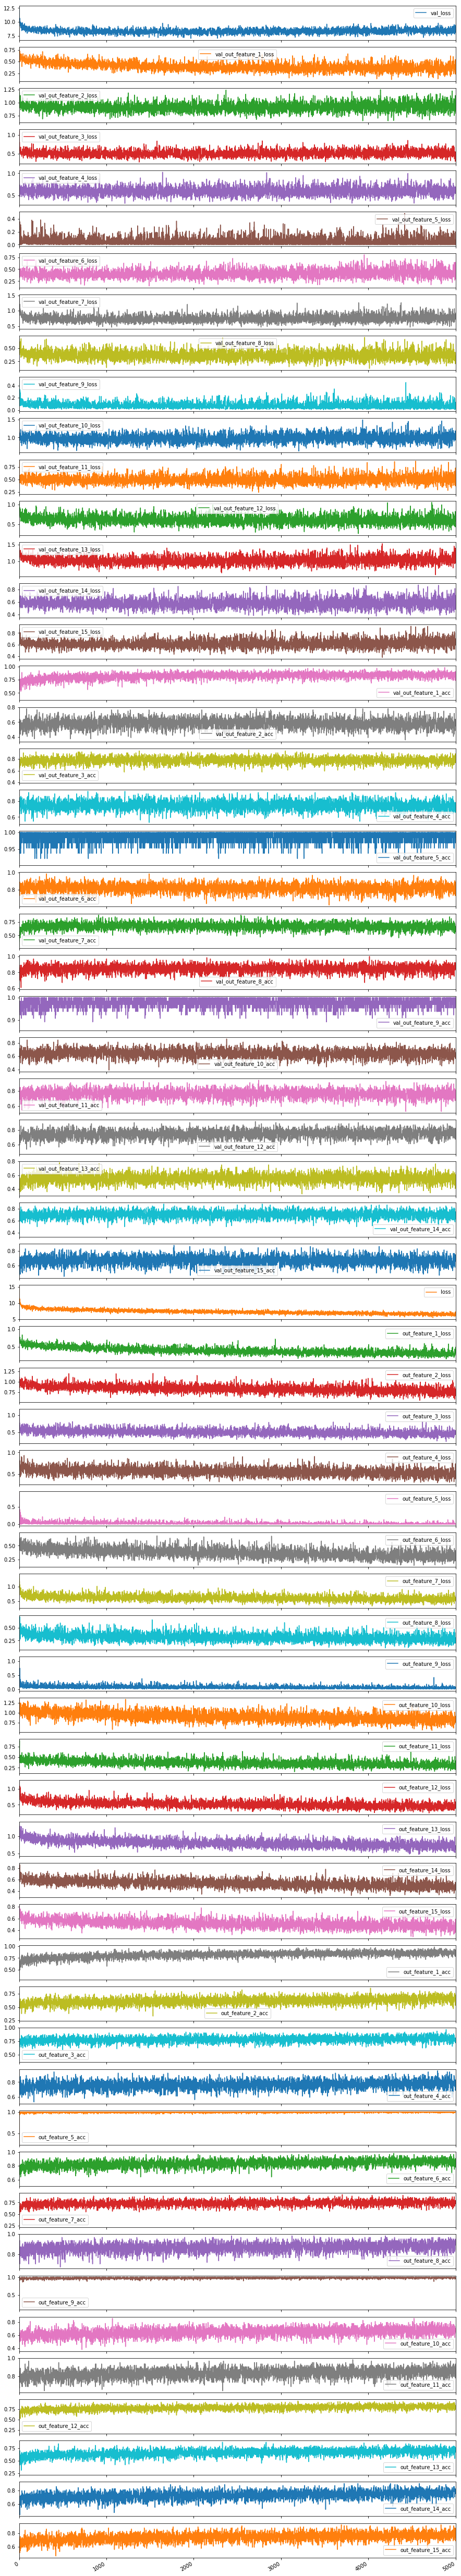

In [9]:
df_hist = pd.DataFrame(hist.history)
df_hist.plot(subplots=True, figsize=(15,100))
print(df_hist['val_loss'].min())

In [10]:
#human_features.load_weights('model.h5')

## Plotting Results 

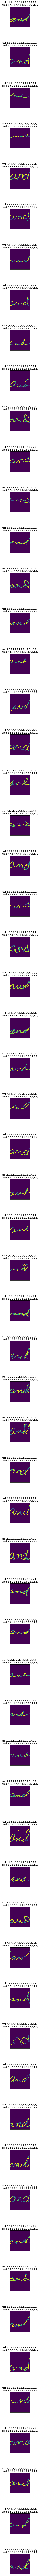

In [11]:
vx,vo=next(validation_datagen)
real_rows = []
pred_rows = []
fig = plt.figure(figsize=(80,200))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=1, wspace=0.05)
for i in range(64):
    real=[]
    real2=''
    for f in range(15):
        real2+=str(np.argmax(vo[f][i])+1)+','
        real.append(np.argmax(vo[f][i])+1)
        real_rows.append(real)
    
    f_probs = human_features.predict(np.expand_dims(vx[i],0))
    pred=[]
    pred2=''
    for prob in f_probs:
        pred2+=str(np.argmax(prob[0])+1)+','
        pred.append(np.argmax(prob[0])+1)
        pred_rows.append(pred)
    ax = fig.add_subplot(64, 1, i + 1, xticks=[], yticks=[])
    ax.imshow(vx[i].reshape((64,64)))
    ax.set_title('real:'+real2+'\n pred:'+pred2)

In [12]:
from scipy.spatial.distance import cosine
from pandas import DataFrame

cols = ['pen_pressure', 'is_lowercase', 'letter_spacing', 'size', 'slantness', 'staff_of_d', 'exit_stroke_d', 'entry_stroke_a', 'dimension', 'is_continuous', 'staff_of_a', 'tilt', 'formation_n', 'constancy', 'word_formation']
sim = {}

real_df = pd.DataFrame.from_records(real_rows, columns=cols)
pred_df = pd.DataFrame.from_records(pred_rows, columns=cols)

for i in real_df:
    sim[i] = (1-cosine(real_df[i],pred_df[i]))

for key,value in sim.items():
    print(str(key) + " : " + str(value))

pen_pressure : 0.9675235222929082
is_lowercase : 0.9361516996396545
letter_spacing : 0.9580028872896189
size : 0.9565563234854495
slantness : 0.9980526988708163
staff_of_d : 0.9727221292883055
exit_stroke_d : 0.8472035028066074
entry_stroke_a : 0.9481535590840814
dimension : 0.9792364931869323
is_continuous : 0.8805334915818286
staff_of_a : 0.9746904854560775
tilt : 0.9771214370930341
formation_n : 0.9298612909762262
constancy : 0.9198170767925039
word_formation : 0.936476714266637


(64, 64, 64, 1) (64, 2)


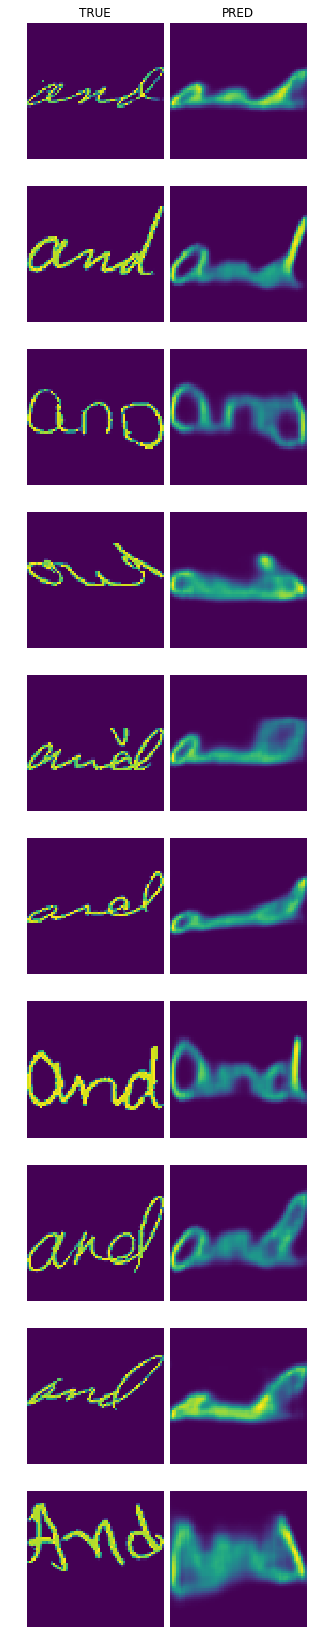

In [13]:
test_g = datagen(batch_size,image_path=val_path,vshift=(-10,10), list_of_writers=val_images)
vx,vy = next(test_g)

print(vx.shape,vy[0].shape)
py = autoencoder.predict(vx[:10])
f,ax = plt.subplots(len(vx[:10]),2)
f.subplots_adjust(hspace = .00, wspace=.05)
f.set_size_inches(5,len(vx[:10])*3)
ax[0,0].set_title('TRUE')
ax[0,1].set_title('PRED')
for i in range(len(vx[:10])):
    
    ax[i,0].imshow(vx[i].reshape((64,64)))
    ax[i,0].axis('off')
    
    ax[i,1].imshow(py[i].reshape((64,64)))
    ax[i,1].axis('off')

['pen_pressure',
 'is_lowercase',
 'letter_spacing',
 'size',
 'slantness',
 'staff_of_d',
 'exit_stroke_d',
 'entry_stroke_a',
 'dimension',
 'is_continuous',
 'staff_of_a',
 'tilt',
 'formation_n',
 'constancy',
 'word_formation']

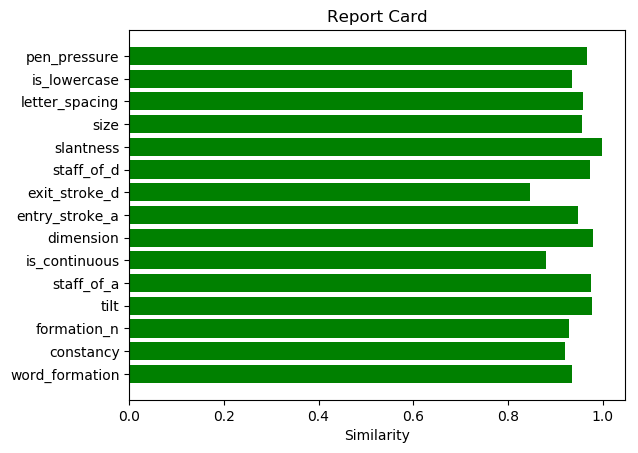

In [14]:
import matplotlib.pyplot as plt

plt.rcdefaults()
fig, ax = plt.subplots()

people = list(sim.keys())
display(people)
y_pos = np.arange(len(people))
performance = list(sim.values())
# error = np.random.rand(len(people))

ax.barh(y_pos, performance, align='center',
        color='green')
ax.set_yticks(y_pos)
ax.set_yticklabels(people)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Similarity')
ax.set_title('Report Card')
plt.savefig("barPlotUnseen.png")
plt.show()